In [1]:
import torch
import pyro

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



A video shows a men part of ISIS beheading another person. The question is identity. The man in the video has a pair of missing fingers. A suspect is identified, has missing fingers and matches other characteristics (travelled to Syria, participated in ISIS etc.). Suspect denies beheading the person in the video.

Key identification evidence:

    suspect's missing fingers are missing in the same places as the missing fingers of the person in the video.
    probability of random match in Swedish population based on police database is assessed to be 2/20,000
    only 2 matches in 20,000 entry database
    matching fingers of people in database are of people who died at the time of the crime

Missing evidence:

    database is based on Swedish population, not ISIS members, random match probability could have been different

Suspect is acquitted or charges because evidence was not robust

Interesting quotation:
"The court explains that a random match probability of 1 in 10 000 would have been sufficient for proof beyond
reasonable doubt, given the other circumstances of the case, if this probability had
been robust, but in the absence of more reference data on people affiliated with ISIS it
is not sufficiently robust for the standard of proof in criminal cases." (p. 142)

Weight question in this case:

    Had an ISIS database been available at trial, how would the overall evidence have changed?


In [2]:
# this is just a definition of a function that we will be using for sampling from the model and
# creating plots of the samples


def plot_from_nodes(
    nodes, filters: Dict[str, float] = None, nodes_to_plot: List[str] = None, bins=20
):
    """
    The plot_from_nodes function takes a dictionary of nodes, processes their values, optionally filters the data,
     and plots histograms for specified nodes. The function then returns the processed DataFrame.
     Parameters:
     - nodes: Dictionary of nodes containing data.
     - filters: Optional dictionary to filter the data based on specified conditions.
     - nodes_to_plot: Optional list of specific nodes to plot. If not provided, plots all nodes.
     - bins: Number of bins for the histograms (default is 20).

     Returns:
     - DataFrame of the processed values.
    """

    values = {
        key: nodes[key]["value"].float().detach().cpu().numpy()
        for key in nodes.keys()
        if nodes[key]["name"] != "samples"
    }

    valuesDF = pd.DataFrame(values)

    if filters is not None:
        for key in filters.keys():
            valuesDF = valuesDF[valuesDF[key] == filters[key]]

    if nodes_to_plot is None:
        nodes_to_plot = values.keys()

    for key in nodes_to_plot:
        plt.figure()
        plt.hist(valuesDF[key], bins=bins, alpha=0.7, color="blue", density=True)
        plt.title(f"{key}, mean: {valuesDF[key].mean()}")
        plt.xlabel("value")
        plt.ylabel("frequency")
        sns.despine()
        plt.show()

    return valuesDF


# TODO add vertical line at 99% quantile with printing its rounded value next to it?

In [3]:
# normalize posterior sample using k bins by binning and calculating frequencies in bins
# using tensors


def normalize_posterior(posterior: torch.Tensor, k: int = 1000) -> torch.Tensor:

    hist = torch.histc(posterior, bins=k)
    return hist / hist.sum()


def weight(posterior: List[float], base=2, k=1000) -> float:

    posterior = normalize_posterior(posterior, k)

    grid_length = k
    x = np.linspace(0, 1, grid_length)
    uniform = beta.pdf(
        x, 1, 1
    )  # def. of a uniform distribution given the size of the posterior

    entropy_uniform = entropy(uniform, base=base)  # entropy H(uniform)
    entropy_posterior = entropy(posterior, base=base)  # entropy H(p)
    return 1 - entropy_posterior / entropy_uniform  # weight = 1 - H(p)/H(uniform)

## BN core with deterministic Bayes' theorem and sampling around it (match evidence)

The general idea is that we compose a parametrized precise Bayesian network-like core with uncertainty about its parameters. For instance in this case, we are essentially dealing with a posterior on source idenity given `prior_identity`, `random_match_probability` and `pr_match_if_identity`. We isolate this parametrized core by just hard-coding the equation for the posterior into a function (in pricniople for more complex cases, we might imagine using approximate methods, such as rejection sampling; there is no need for this here).

In [4]:
# deterministic core
# returns precise posterior on identity given the three inputs


def match_posterior(
    prior_identity: torch.tensor,
    random_match_probability: torch.tensor,
    pr_match_if_identity=torch.tensor(1.0),
):

    numerator = pr_match_if_identity * prior_identity
    denominator = (
        pr_match_if_identity * prior_identity
        + (1 - prior_identity) * random_match_probability
    )

    return numerator / denominator

Now we capture our uncertainty about the prior and RMP (probablity of match if identity defaults to 1 for the sake of illustration). We do so by sampling "above the model" and then running the precise core with those samples.


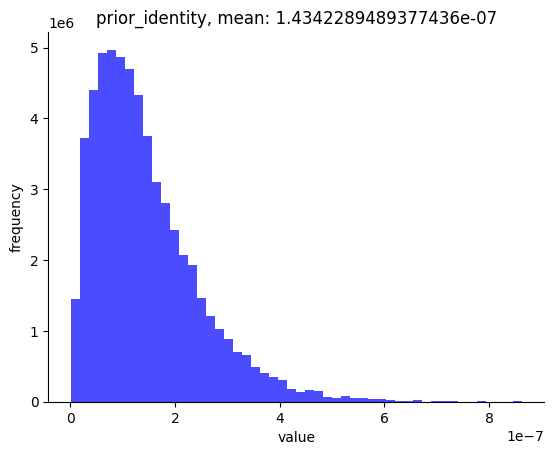

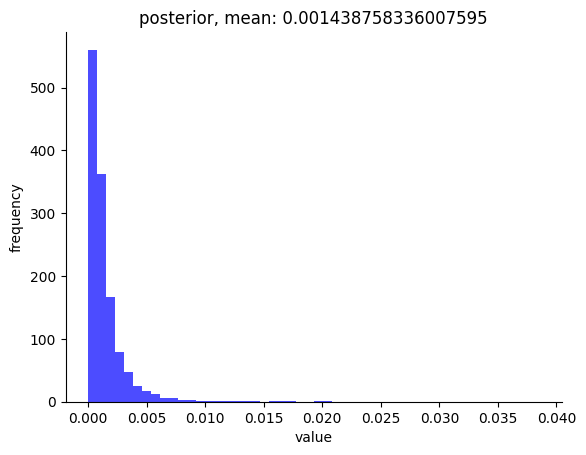

99% certainty interval of posterior starts at 4.0306384144059854e-05
Weight of the prior: 0.13779348054290796
Weight of the posterior: 0.3436640343718399


In [5]:
def fingers_just_sweden():
    # Sample the probability of being the person responsible (a single value) from a Beta distribution
    prior_identity = pyro.sample(
        "prior_identity", dist.Beta(2, 1.4e7)
    )  # suppose1 out of 1.4 e7
    # in Sweden

    random_match_probability = pyro.sample(
        "random_match_probability", dist.Beta(3, 20001)
    )
    # random match probability for Sweden, say 2 other living people with similarly
    # severed fingers
    # in a sample of size 20k

    posterior = pyro.deterministic(
        "posterior",
        match_posterior(prior_identity, random_match_probability),
        event_dim=0,
    )

    return posterior


with pyro.plate("samples", 10000):
    with pyro.poutine.trace() as tr_sweden:
        posterior = fingers_just_sweden()

nodes_sweden = tr_sweden.trace.nodes

# Plot the specified nodes, no need to filter as we used Bayes' theorem here

table = plot_from_nodes(
    nodes_sweden, nodes_to_plot=["prior_identity", "posterior"], bins=50
)

print(
    f"99% certainty interval of posterior starts at {np.quantile(table['posterior'], 0.005)}"
)

weight_prior = weight(nodes_sweden["prior_identity"]["value"])
weight_posterior = weight(nodes_sweden["posterior"]["value"])

print(f"Weight of the prior: {weight_prior}")
print(f"Weight of the posterior: {weight_posterior}")

/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


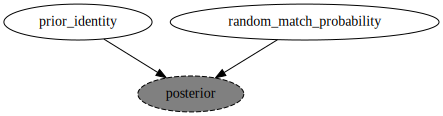

In [6]:
pyro.render_model(fingers_just_sweden)

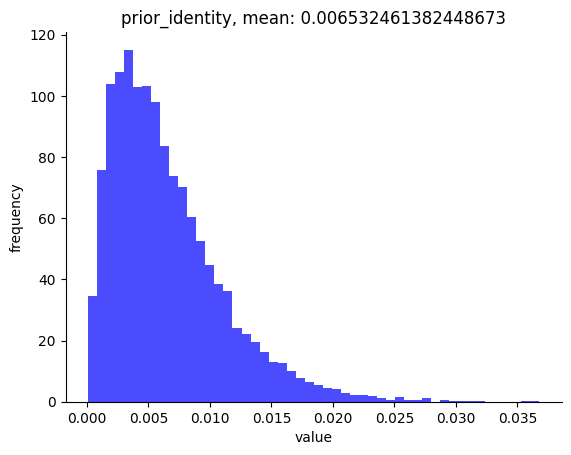

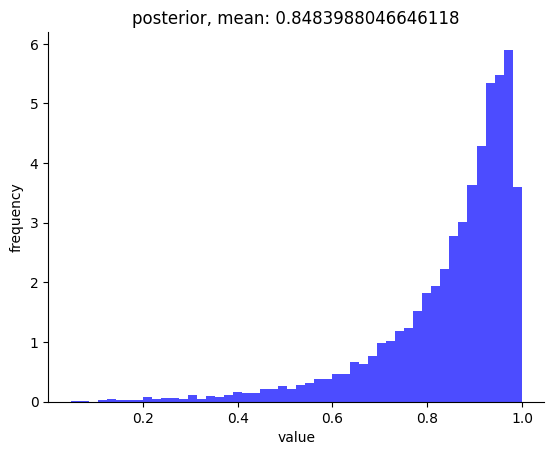

99% certainty interval of posterior starts at 0.23285198606550694
Weight of the prior: 0.1288292042277085
Weight of the posterior: 0.1334342834775244


In [7]:
def fingers_with_isis():

    # Sample the probability of being the person responsible (a single value) from a Beta distribution
    prior_identity = pyro.sample(
        "prior_identity", dist.Beta(2, 301)
    )  # suppose 1 in 300 fighters from Sweden

    rmp_swedish = pyro.sample("rmp_swedish", dist.Beta(3, 20001))

    rmp_isis = pyro.sample(
        "pr_fingers_if_isis", dist.Uniform(rmp_swedish, 10 * rmp_swedish)
    ).clamp(0, 1)
    # charitably, chance of fingers if in isis
    # it's assumed that the probability of having fingers missing in exactly the same way if in ISIS
    # is up to 10 times higher than if Swedish
    # clamp just ensures that the value is between 0 and 1

    posterior = pyro.deterministic(
        "posterior",
        match_posterior(
            prior_identity=prior_identity, random_match_probability=rmp_isis
        ),
        event_dim=0,
    )

    return posterior


with pyro.plate("samples", 10000):
    with pyro.poutine.trace() as tr_isis:
        posterior = fingers_with_isis()

nodes_isis = tr_isis.trace.nodes


table_isis = plot_from_nodes(
    nodes_isis, nodes_to_plot=["prior_identity", "posterior"], bins=50
)

print(
    f"99% certainty interval of posterior starts at {np.quantile(table_isis['posterior'], 0.005)}"
)

weight_prior = weight(nodes_isis["prior_identity"]["value"])
weight_posterior = weight(nodes_isis["posterior"]["value"])

print(f"Weight of the prior: {weight_prior}")
print(f"Weight of the posterior: {weight_posterior}")

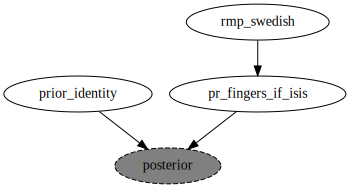

In [8]:
pyro.render_model(fingers_with_isis)

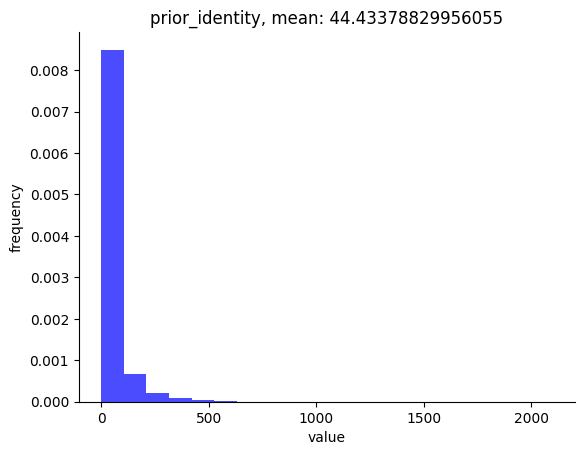

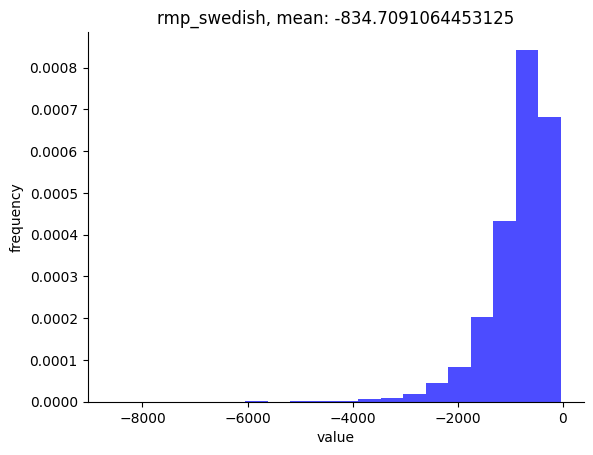

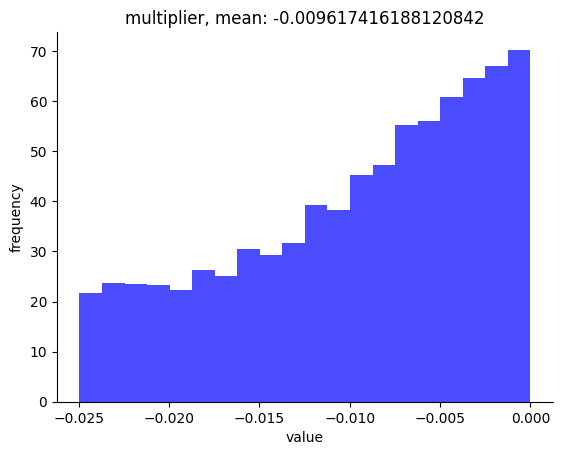

In [156]:

def fingers_with_grads():

    multiplier = pyro.deterministic("multiplier", torch.tensor(10.0).repeat(10000))
    multiplier.requires_grad = True # ensure autodiff is enabled


    prior_identity = pyro.sample(
            "prior_identity", dist.Beta(2, 301))
    prior_identity.requires_grad = True # ensure autodiff is enabled

    rmp_swedish = pyro.sample("rmp_swedish", dist.Beta(3, 20001))
    rmp_swedish.requires_grad = True # ensure autodiff is enabled

    rmp_isis = pyro.sample(
            "pr_fingers_if_isis", dist.Uniform(rmp_swedish, multiplier * rmp_swedish)
        ).clamp(0, 1)
    # ensure autodiff is enabled


    posterior = pyro.deterministic(
        "posterior",
        match_posterior(prior_identity=prior_identity, random_match_probability=rmp_isis),
        event_dim=0,
    )


    # Perform backward pass to compute gradients
    posterior.backward(gradient=torch.ones_like(posterior))

    # Extract gradients
    gradient_prior_identity = pyro.deterministic("gradient_prior_identity", prior_identity.grad, event_dim=0)
    gradient_rmp_swedish = pyro.deterministic("gradient_rmp_swedish", rmp_swedish.grad, event_dim=0)
    gradient_multiplier = pyro.deterministic("gradient_multiplier", multiplier.grad, event_dim=0)

    gradients = {"prior_identity": gradient_prior_identity, "rmp_swedish": gradient_rmp_swedish, "multiplier": gradient_multiplier}

    return gradients

with pyro.plate("samples", 10000):
    gradients = fingers_with_grads()


for key in gradients.keys():
    plt.figure()
    plt.hist(gradients[key], bins=20, alpha=0.7, color="blue", density=True)
    plt.title(f"{key}, mean: {gradients[key].mean()}")
    plt.xlabel("value")
    plt.ylabel("frequency")
    sns.despine()
    plt.show()

